## import

In [1]:
from datetime import datetime
import time
import os
import pandas as pd
import numpy as np
import healpy as hp
import seaborn as sns
from astropy.io import fits
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from healpy.fitsfunc import read_map
import matplotlib.style as style
from utils_planck import *
import camb
from camb import model, initialpower
from scipy.optimize import curve_fit
from pylab import cm

%config InlineBackend.figure_format = 'retina'                                    # so you can see plots in HD :) 
#jtplot.style(theme='grade3', context='talk', ticks=True, grid=True)
style.use('tableau-colorblind10')
colors = sns.color_palette("colorblind").as_hex()
#style.use('seaborn-colorblind')
today = datetime.today().strftime('%Y-%b-%d')

# Tableau Color Blind 10
tableau_colors = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]
for i in range(len(tableau_colors)):  
    r, g, b = tableau_colors[i]  
    tableau_colors[i] = (r / 255., g / 255., b / 255.)

############### CMB colormap
from matplotlib.colors import ListedColormap
colombi1_cmap = ListedColormap(np.loadtxt("Planck_Parchment_RGB.txt")/255.)
colombi1_cmap.set_bad("gray") # color of missing pixels
colombi1_cmap.set_under("white") # color of background, necessary if you want to use
# this colormap directly with hp.mollview(m, cmap=colombi1_cmap)
cmap = colombi1_cmap

## extract CMB maps and masks

In [2]:
# Define data fixed params
NSIDE = 2048                                                                      # given in the name of the maps
APO = 5                                                                           # apodization length
HDU = 1
FREQ = 143 
gal_cover = 80                                                                    # % of cover in galacitc plane

BAD_DATA = -1.6375e+30

H_0 = 67.5                                                                        # Set parameter from Planck

# Extract data in directly from .npy files
start1 = time.time()
print(f'Started Planck data extraction:')
print('='*90)
data_filenames = ['HFI_SkyMap_143_2048_R3.01_halfmission-1.npy',
                  'HFI_SkyMap_143_2048_R3.01_halfmission-2.npy',
                  f'HFI_Mask_GalPlane-apo{APO}_2048_R2.00_fsky={gal_cover/100}.npy',
                  'HFI_Mask_PointSrc_2048_R2.00.npy' ,
                  'Bl_T_R3.01_fullsky_143hm1x143hm1.npy',
                  'Bl_T_R3.01_fullsky_143hm1x143hm2.npy']

arrays = []
for filename in data_filenames:
    arrays.append(np.load('data/'+filename))
    print(f'{filename} was extracted succesfully.')
    print('-'*75)

sky_hm1, sky_hm2, mask_gp, mask_ps, beam_hm1, beam_hm2 = arrays 

end1 = time.time()
print('='*90)
print(f'It took {end1-start1:.2f}s. to extract the Planck data files.')

Started Planck data extraction:
HFI_SkyMap_143_2048_R3.01_halfmission-1.npy was extracted succesfully.
---------------------------------------------------------------------------
HFI_SkyMap_143_2048_R3.01_halfmission-2.npy was extracted succesfully.
---------------------------------------------------------------------------
HFI_Mask_GalPlane-apo5_2048_R2.00_fsky=0.8.npy was extracted succesfully.
---------------------------------------------------------------------------
HFI_Mask_PointSrc_2048_R2.00.npy was extracted succesfully.
---------------------------------------------------------------------------
Bl_T_R3.01_fullsky_143hm1x143hm1.npy was extracted succesfully.
---------------------------------------------------------------------------
Bl_T_R3.01_fullsky_143hm1x143hm2.npy was extracted succesfully.
---------------------------------------------------------------------------
It took 53.03s. to extract the Planck data files.


## data quality check

In [3]:
sky_hm1, sky_hm2 = clean_skydata(sky_hm1), clean_skydata(sky_hm2)

Carrying out data quality of sky map:
--------------------------------------------------------------------------------
Before data clean, the mean of the sky map corresponds to:  -2.12e+26
Skymap contains bad data
After data clean, the mean of the sky map corresponds to: 1.57e-04
Data Quality check completed.
Carrying out data quality of sky map:
--------------------------------------------------------------------------------
Before data clean, the mean of the sky map corresponds to:  -2.09e+27
Skymap contains bad data
After data clean, the mean of the sky map corresponds to: 1.57e-04
Data Quality check completed.


## plot maps

In [4]:
mask = mask_gp.astype(np.bool_)
p_map = sky_hm1 

p_map_masked = hp.ma(p_map)
p_map_masked.mask = np.logical_not(mask)
#p_map_masked[p_map_masked.mask] = hp.UNSEEN

0.0 180.0 -180.0 180.0


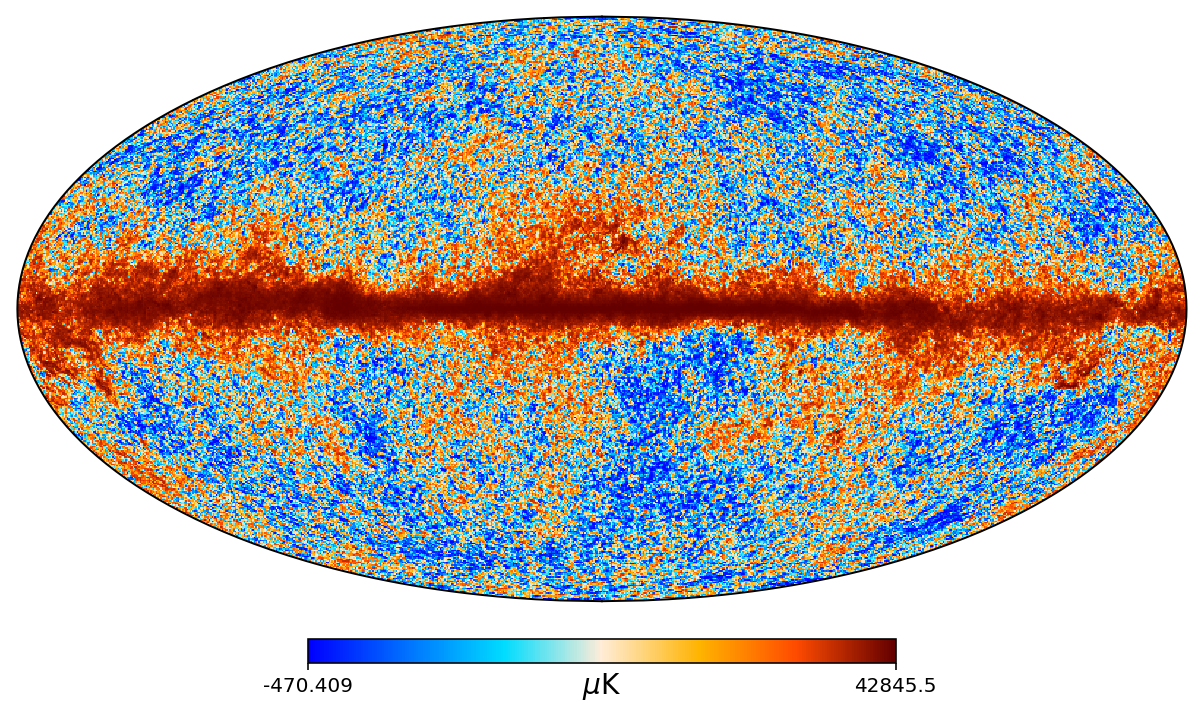

In [5]:
hp.mollview(p_map*1e6, norm='hist', cmap=cmap,
            unit="$\mu$K", title='',
            notext=True)

hp.graticule(local=True, dmer=360,dpar=360,alpha=0)

0.0 180.0 -180.0 180.0


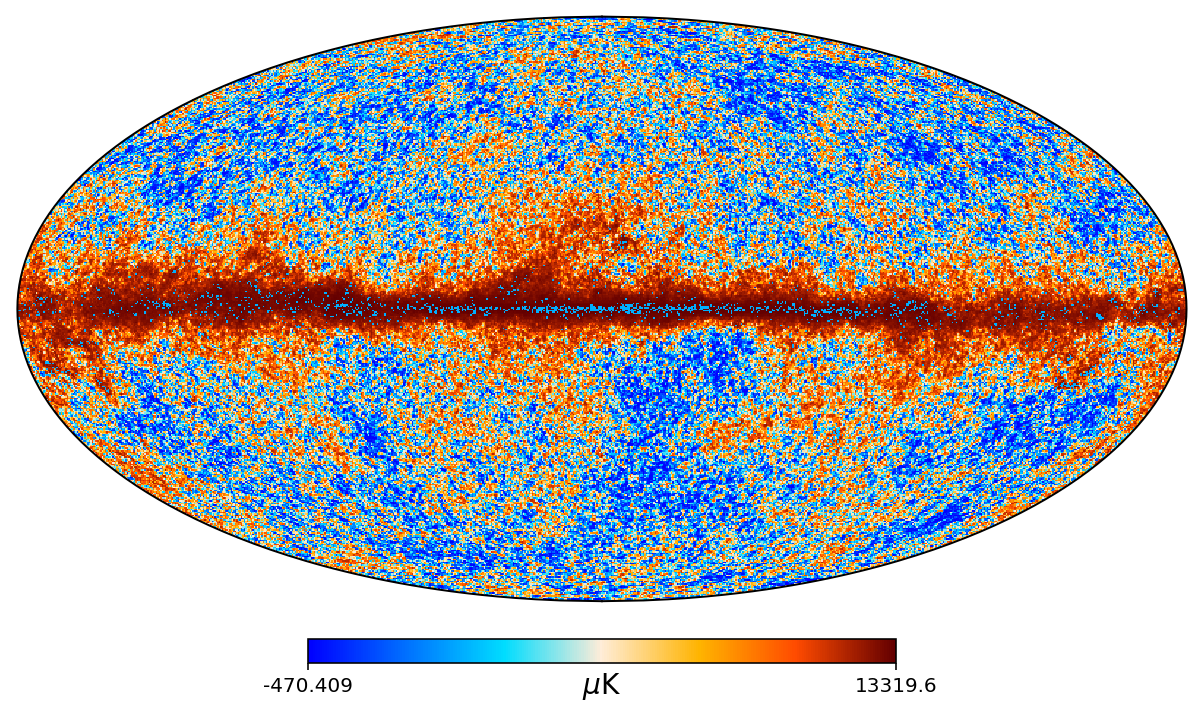

In [6]:
hp.mollview(p_map*mask_ps*1e6, norm='hist', cmap=cmap,
            unit="$\mu$K", title='',
            notext=True)

hp.graticule(local=True, dmer=360,dpar=360,alpha=0)

0.0 180.0 -180.0 180.0


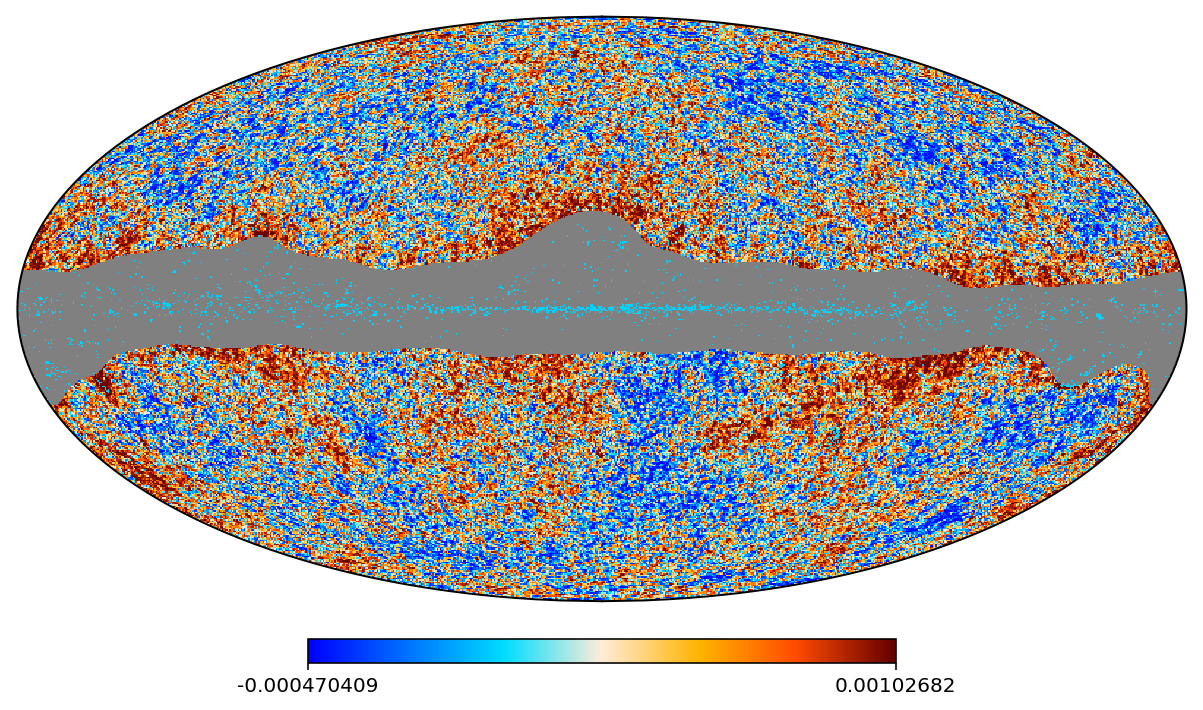

In [7]:
mask = mask_gp.astype(np.bool_)
p_map = sky_hm1 

p_map_masked = hp.ma(p_map)
p_map_masked.mask = np.logical_not(mask)
#p_map_masked[p_map_masked.mask] = hp.UNSEEN

hp.mollview(p_map_masked.filled()*mask_ps, norm='hist', cmap=cmap,
            cbar=True, title='',
            notext=True)

hp.graticule(local=True, dmer=360,dpar=360,alpha=0)

In [8]:
plot_all_maps = False
if plot_all_maps:
    plot_array = [sky_hm1, sky_hm1*mask_ps, sky_hm1*mask_gp*mask_ps, 
              sky_hm2, sky_hm2*mask_ps, sky_hm2*mask_gp*mask_ps]

    titles = ['Sky', f'Sky + Mask_GP (APO{APO} - {gal_cover})', f'Sky + Mask_GP + Mask_PS (APO{APO} - {gal_cover}% coverage)']
    
    for i, arr in enumerate(plot_array):
        hp.mollview(arr*10**6, coord=["G"],  norm="hist",
                    title=f"Norm. Histogram for HM{1 if i < 3 else 2}: {titles[i%3]}", 
                    unit="$\mu$K norm.", cmap=cmap)

        hp.graticule()

## compute spherical harmoncis

In [9]:
a_lm_1 = find_spherical_harmonics(sky_hm1, mask_gp, mask_ps)
a_lm_2 = find_spherical_harmonics(sky_hm2, mask_gp, mask_ps)

It took 198.47 s. to compute a_lm
It took 135.37 s. to compute a_lm


## compute actual cross power spectrum

In [10]:
# find power spectrum and bin it (remove edges too i.e. clean power spectrum)
D_l, C_l = find_power_spectrum(a_lm_1, a_lm_2, beam_hm1, beam_hm2, which_return='both')
l_planck, Cl_planck = clean_power_spectrum(C_l)

8006001
It took 2.96 s. to compute C_l


## find a fit for the 1st peak of the cross power spectrum

In [11]:
# find an approximate fit for the first peak
N_l = 2536                                                                                               # lmax for pixwindow
l_a, l_b = 100, 320
ind_fit_a, ind_fit_b = np.where(l_planck == l_a)[0][0], np.where(l_planck == l_b)[0][0]

params_p1, cov_p1 = curve_fit(model_cl, l_planck[ind_fit_a:ind_fit_b], Cl_planck[ind_fit_a:ind_fit_b],
                             p0=[ 1.81914268e+03,-8.19192815e-02 ,2.11136936e+02]) 

l_fit = np.arange(N_l+1)
Cl_fit = model_cl(l_fit,*params_p1)

# The peak is now a fitting parameter, and the uncertainty is given in the fitting covariance matrix
lp_planck = params_p1[-1]
sigma_lp_planck = np.sqrt(np.diag(cov_p1)[-1])

## compute boltzmann code for flat geometry

In [28]:
# Set model params for fit
n_models = 4
guess = 0
delta = 0.02                                                                           # spacing in omega_k between models

omega_k = np.linspace(guess - (delta*n_models)/2, guess + (delta*n_models)/2, num=n_models)

boltzm_cosmo_params = {
    'omega_baryons': [0.022 for _ in range(n_models)],
    'omega_cdm': [0.122 for _ in range(n_models)],
    'omega_curv': omega_k
}

start_bc = time.time()
# compute power spectrum for each models and its associated l_peak
l_boltz, Cl_boltz, l_peaks_bc = [], [], []

print("Started computation of BC power spectrum for different cosmologies:")
print("="*70)
for i in range(n_models):
    omega_b_i, omega_cdm_i, omega_k_i = boltzm_cosmo_params['omega_baryons'][i], boltzm_cosmo_params['omega_cdm'][i], boltzm_cosmo_params['omega_curv'][i]
    l_i, Cl_i = boltzmann_cl(omega_b_i, omega_cdm_i, omega_k_i, H_0)
    l_boltz.append(l_i) 
    Cl_boltz.append(Cl_i)
    # find the peak
    l_peakbz_i = peak_finder(l_boltz[i], Cl_boltz[i])
    l_peaks_bc.append(l_peakbz_i)
    
    print(f"A model was succesfully constructed for: omega_bary = {omega_b_i:.3f}, omega_cdm = {omega_cdm_i:.3f}, omega_k = {omega_k_i:.3f} ")
    print("-"*100)

l_peaks_bc = np.array(l_peaks_bc)
end_bc = time.time()
print(f'Computing the Boltzmann Code cross-power spectra took {end_bc-start_bc:.2f} s.')
print("="*70)

Started computation of BC power spectrum for different cosmologies:
A model was succesfully constructed for: omega_bary = 0.022, omega_cdm = 0.122, omega_k = -0.040 
----------------------------------------------------------------------------------------------------
A model was succesfully constructed for: omega_bary = 0.022, omega_cdm = 0.122, omega_k = -0.013 
----------------------------------------------------------------------------------------------------
A model was succesfully constructed for: omega_bary = 0.022, omega_cdm = 0.122, omega_k = 0.013 
----------------------------------------------------------------------------------------------------
A model was succesfully constructed for: omega_bary = 0.022, omega_cdm = 0.122, omega_k = 0.040 
----------------------------------------------------------------------------------------------------
Computing the Boltzmann Code cross-power spectra took 123.59 s.


## plotting Boltzmann-Code C_ls

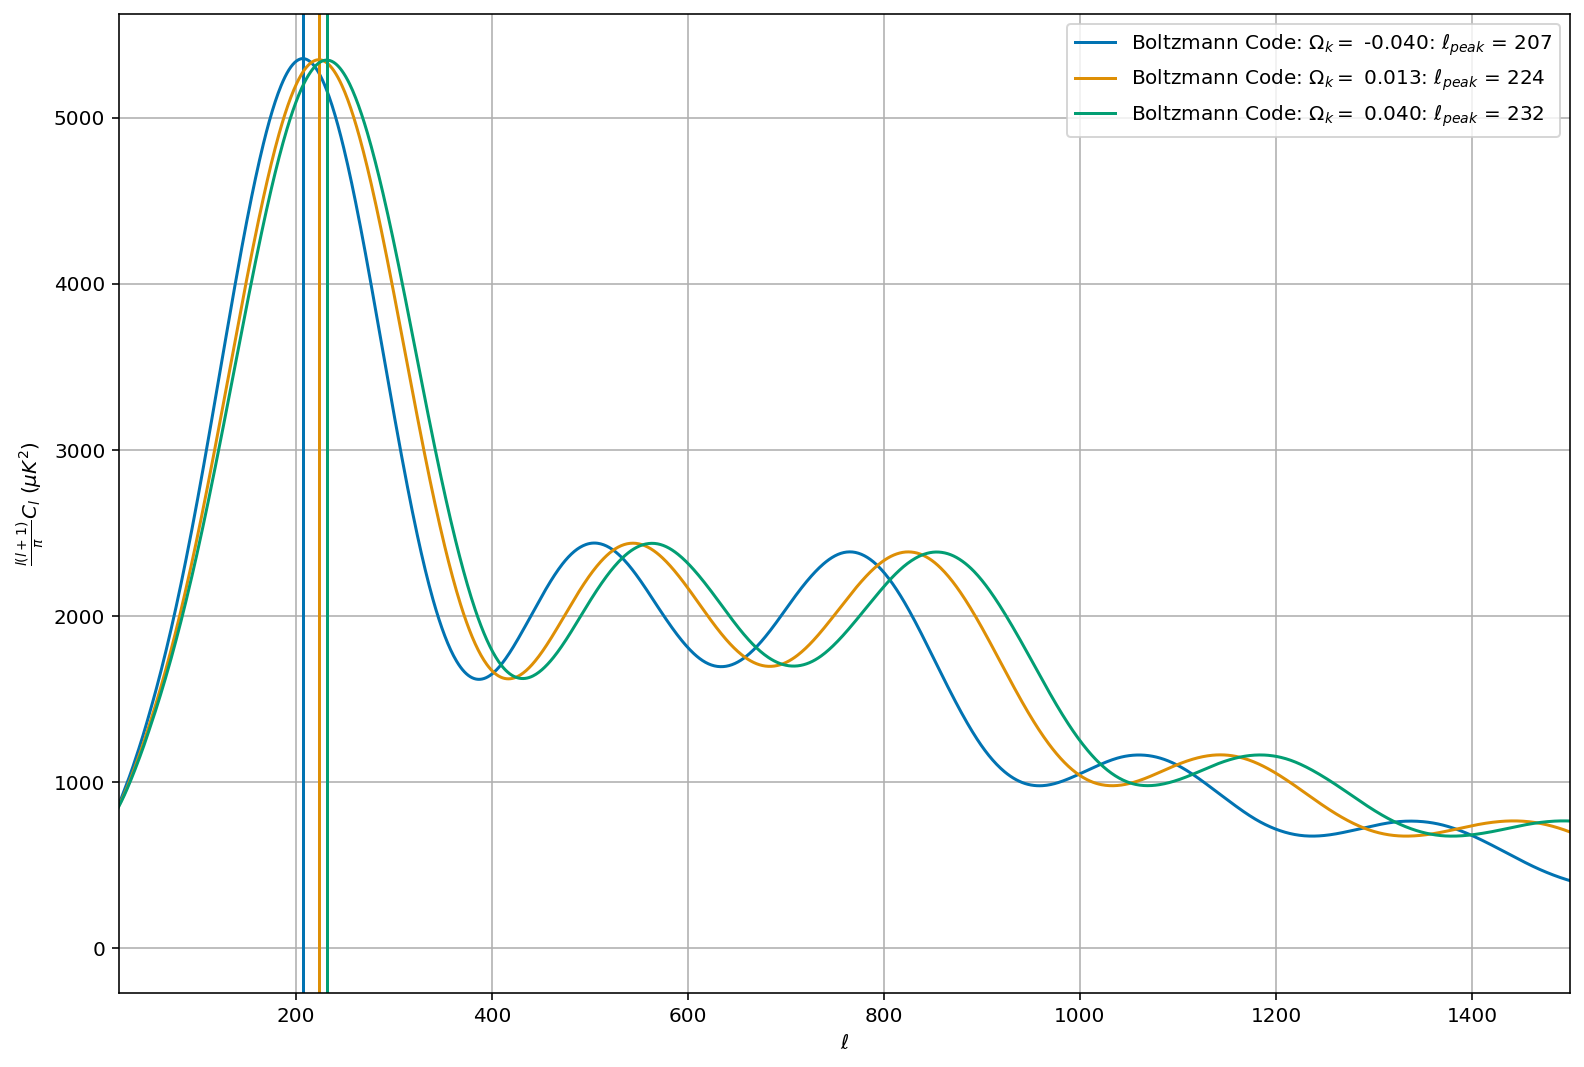

In [32]:
# Plotting the Planck spectra and model comparison

#norm_factor = Cl_boltz_0[l_peaks_bc[0]]/Cl_fit[np.where(Cl_fit == np.max(Cl_fit))[0][0]] 
norm_factor = np.mean(Cl_boltz[0][l_a:l_b]/Cl_fit[l_a:l_b])

fig, ax = plt.subplots(figsize=(13,9))

# plotting 3 evenly spaced boltzman codes for reference
plot_bc = True
if plot_bc:
    k = 0
    for j in [0,len(Cl_boltz)//2,-1]:
        
        omega_k_j = boltzm_cosmo_params['omega_curv'][j]
        ax.plot(l_boltz[j], Cl_boltz[j], '-', 
                label='Boltzmann Code: $\Omega_k=$ ' + f'{omega_k_j:.3f}: ' + r'$\ell_{peak}$ = '+f'{l_peaks_bc[j]:.0f}',
                color=colors[k%5])

        show_peak = True
        if show_peak:
            ax.axvline(l_peaks_bc[j], color=colors[k%5])
            #ax.text(l_peakbz_i+6, 400 + 400*i, r'$\el\ell_{peak}$ = '+f'{l_peakbz_i:.0f}', color=colors[3+i])
        
        k += 1 
#ax.set_yscale('log')
ax.set_xlim([20,1500])

ax.set_xlabel('$\ell$')
ax.set_ylabel(r'$\frac{l(l+1)}{\pi} C_l$ $(\mu K^2)$')

plt.legend(loc=0)
plt.grid(True)

save_fig = False
if save_fig:
    cps_title = f'plots/BoltzCode_Cls_{today}.png'
    try:
        plt.savefig(cps_title, format='png', dpi=200, pad_inches=0.1, bbox_inches='tight', facecolor='w')
    except FileNotFoundError:
        os.mkdir('plots')
        plt.savefig(cps_title, format='png', dpi=200, pad_inches=0.1, bbox_inches='tight', facecolor='w')
plt.show()

## plot normalized Planck C_l

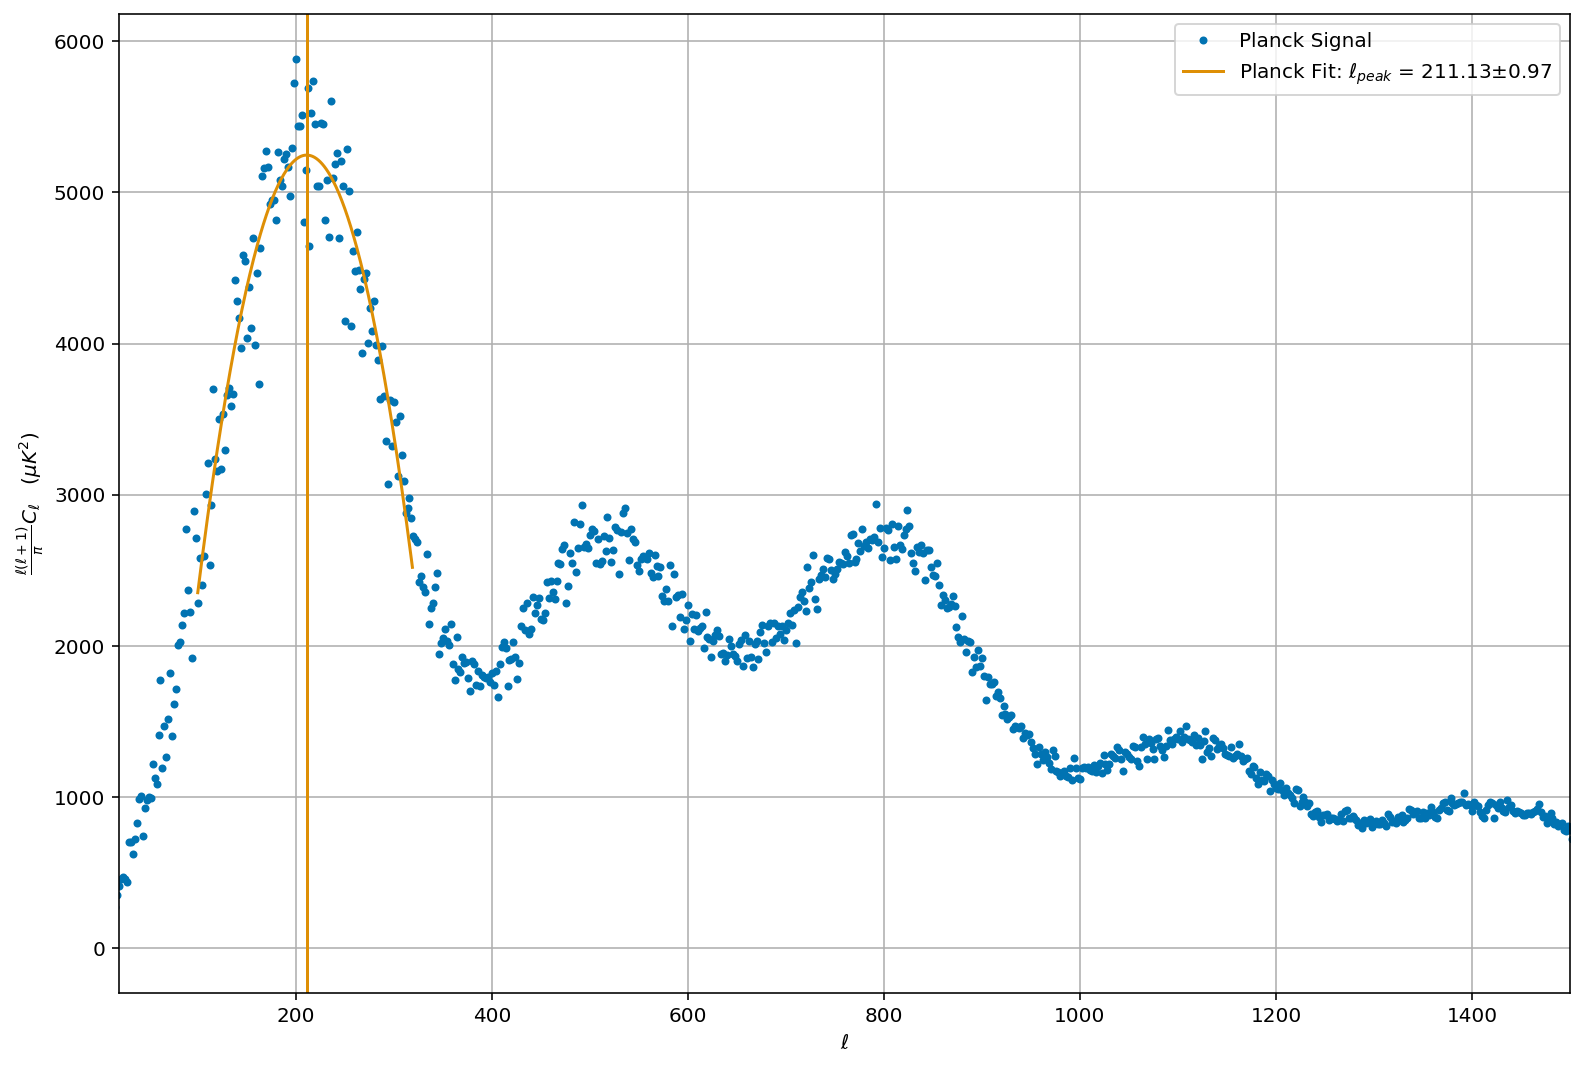

In [33]:
norm_factor = np.mean(Cl_boltz[0][l_a:l_b]/Cl_fit[l_a:l_b])

fig, ax = plt.subplots(figsize=(13,9))

ax.plot(l_planck, norm_factor*Cl_planck, 'o', markersize=3, label='Planck Signal', color=colors[0])
ax.plot(l_fit[l_a:l_b], norm_factor*Cl_fit[l_a:l_b], '-',  color=colors[1], 
        label=f'Planck Fit: ' +r'$\ell_{peak}$ = '+f'{lp_planck:.2f}' + '$\pm$' + f'{sigma_lp_planck:.2f}') 
ax.axvline(lp_planck, color=colors[1])

ax.set_xlim([20,1500])

ax.set_xlabel('$\ell$')
ax.set_ylabel(r'$\frac{\ell(\ell+1)}{\pi} C_{\ell}$   $(\mu K^2$)')
plt.legend()
plt.grid(True)

save_fig = False
if save_fig:
    cps_title = f'plots/Planck_Cl_{FREQ}x{FREQ}__{gal_cover}perc_{today}.png'
    try:
        plt.savefig(cps_title, format='png', dpi=200, pad_inches=0.1, bbox_inches='tight',facecolor='w')
    except FileNotFoundError:
        os.mkdir('plots')
        plt.savefig(cps_title, format='png', dpi=200, pad_inches=0.1, bbox_inches='tight',facecolor='w')
plt.show()

### Estimating $\Omega_k$ for the CMB signal

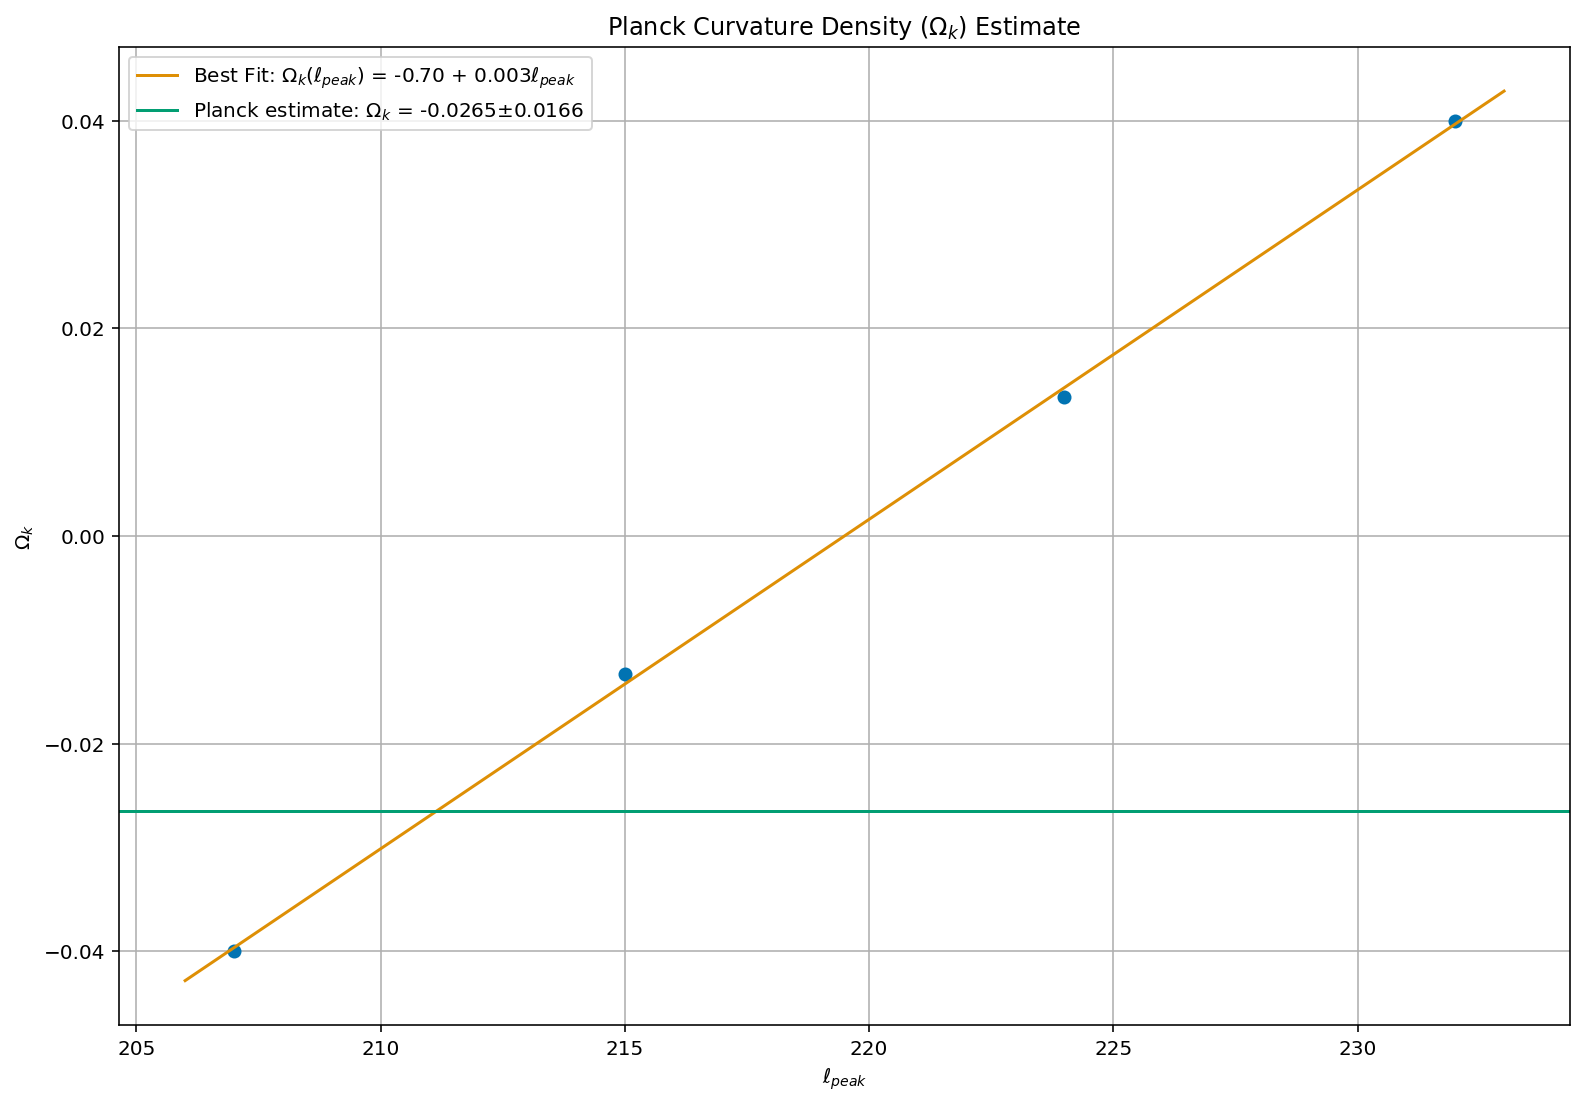

In [34]:
# Find a fit for omega_k vs. l_peak for the Boltzmann code
params_p2, cov_p2 = np.polyfit(l_peaks_bc, omega_k, deg=1, cov=True)            # highest order coefficients are returned first
a1_lin, a0_lin = params_p2
sigma_a1, sigma_a0 = np.sqrt(np.diag(cov_p2))

l_peak_fit = np.linspace(l_peaks_bc[0]-1,l_peaks_bc[-1]+1, num=5000)
om_k_fit = a1_lin*l_peak_fit + a0_lin

# find omega_k estiamte for planck data
om_k_planck = lp_planck*a1_lin + a0_lin

# propagate uncertainty to find sigma_omegak
def sigma_omk(l, a0, a1, 
              s_l, s_a0, s_a1):
    '''
    Propagation of uncertainties for curvature density parameter
    '''
    var = (a1*s_l)**2 + s_a0**2 + (l*s_a1)**2
    
    return np.sqrt(var)

sigma_omega_k = sigma_omk(lp_planck, a0_lin, a1_lin, sigma_lp_planck, sigma_a0, sigma_a1)   # sigma_a0, sigma_a1 = 0 as otherwise uncertainty becomes too great

# Finally plot the curvature density fit
fig, ax = plt.subplots(figsize=(13,9))
ax.plot(l_peaks_bc, omega_k, 'o', color=colors[0])
ax.plot(l_peak_fit, om_k_fit, color=colors[1],
        label='Best Fit: $\Omega_k(\ell_{peak})$ = ' + f'{a0_lin:.2f} + {a1_lin:.3f}'+'$\ell_{peak}$')
ax.axhline(om_k_planck, color=colors[2],
           label='Planck estimate: $\Omega_k$ = ' + f'{om_k_planck:.4f}' +'$\pm$' + f'{sigma_omega_k:.4f}')

ax.set_title(f'Planck Curvature Density ($\Omega_k$) Estimate')
ax.set_xlabel('$\ell_{peak}$')
ax.set_ylabel(r'$\Omega_k$')
plt.legend(loc=0)
plt.grid(True)

save_fig = False
if save_fig:
    k_title = f'plots/CMB_DensityCurvature_{FREQ}x{FREQ}_{today}.png'
    try:
        plt.savefig(k_title, format='png', dpi=200, pad_inches=0.1, bbox_inches='tight')
    except FileNotFoundError:
        os.mkdir('plots')
        plt.savefig(k_title, format='png', dpi=200, pad_inches=0.1, bbox_inches='tight')

plt.show()